In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stripROtools
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import crystalball

from stripROtools import colors
from stripROtools import GetTransErrs
from stripROtools import gaus2
from stripROtools import Mismeasurment_vs_z
from stripROtools import random_three_vector
from stripROtools import plot_track

In [2]:
# Solid angle range in theta [degrees]
theta_min = 15
theta_max = 30


In [3]:
# dataframe with time offset info
T_off = pd.read_pickle("./data/time_offset.pk")
T_off


,Name,Mu,Mu_err,Sigma,Sigma_err
0,UH DLC a,-6.684141,0.031719,16.382493,0.024764
1,UH DLC b,-5.208232,0.034228,16.305925,0.026783
2,UH DLC c,6.752723,0.038583,14.113659,0.031446
3,UH DLC d,6.852294,0.058807,14.800689,0.048234
4,UH NoDLC a,5.703480,0.075588,19.574833,0.061573
5,UH NoDLC b,5.473110,0.114114,19.799337,0.092169
6,UH NoDLC c,25.241775,0.189180,18.082547,0.159142
7,UH NoDLC d,20.674842,0.698955,17.886667,0.626167
8,UoS,-11.400385,0.026963,15.290716,0.021079


# Read dE/dx data from SRIM

In [4]:
# Load dEdx data simulated with SRIM
dEdx_data = np.loadtxt("./data/srim_po210_heco2.txt",skiprows=4)

dEdx_data = dEdx_data.T

# convert from angstrom to cm
dEdx_data[0] = dEdx_data[0]*1e-8

#dEdx resolution as seen in dEdx_data[0] 
delta_x = 0.1

# convert to eV/cm
dEdx_data[1] = dEdx_data[1]/1e-8
dEdx_data[2] = dEdx_data[2]/1e-8

dEdx = dEdx_data[1] + dEdx_data[2]




Text(0, 0.5, 'dE/dx [eV/cm] ')

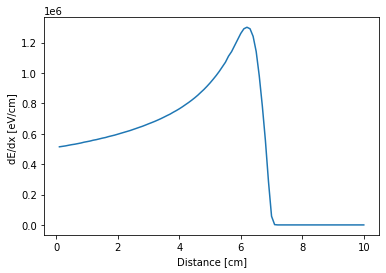

In [24]:
plt.plot(dEdx_data[0],dEdx)
plt.xlabel("Distance [cm]")
plt.ylabel("dE/dx [eV/cm] ")


# Simulate Po210 alpha tracks

In [5]:
# The paramters, in order, are:
# number of simulations
# minimum angle to vertical [degrees] - this is based  on requiring a min. of 5 hits
# maximum angle to vertical [degrees]
# drfit length [cm]
# Apply diffusion T/F
# Transverse diffusion coefficent from Magboltz [cm/sqrt(cm)]
# W-value as obtained using degrad

def sim_p210(n_sims = 500, theta_min = theta_min, theta_max = theta_max, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2):

    tracks = pd.DataFrame(columns = ['direction', 'start', 'track'])

    for i in range(n_sims):

        # draw a random direction within specified solid angle (pointing down towards the readout plane)
        v = random_three_vector(theta_min,theta_max)

        # Maximumm track length of alpha track
        L_max = -DL/v[2]

        # Length segments we will distribute charge on, 0.1 is the resolution of length of the SRIM simulation
        L_segments = np.arange(0,L_max,0.1)

        # Edges of the length segments we will distribute charge on (all edges are listed)
        L_edges = np.append(L_segments,L_max)

        # Energy deposited in each segment given dEdx (energy in each bin is listed)
        E_segments = dEdx[0:len(L_segments)]*np.diff(L_edges)

        # Compute corresponding number of ionizaed eletrons using energy deposited per segment divided by W-value
        Ne_segments = np.round(E_segments/W).astype("int")

        #find left and right edges for each bin
        Left_edges = L_segments[0:-1]
        Right_edges = L_segments[1:]

        track = np.empty((0,3))

        for N,left_edge,right_edge in zip(Ne_segments,Left_edges,Right_edges):

            Ts = np.random.uniform(low=left_edge,high=right_edge,size=N)

            if Diff == False:

                x_vals = Ts*v[0]
                y_vals = Ts*v[1]
                z_vals = DL + Ts*v[2]

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)
            
            elif Diff == True:

                z_vals = DL + Ts*v[2]

                x_vals = Ts*v[0] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                y_vals = Ts*v[1] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                z_vals = z_vals + DLong*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)

        x_rand = np.random.uniform()-0.5
        y_rand = np.random.uniform()-0.5

        track[:,0] = track[:,0]+x_rand # randomize x position (1 cm random uniform dist)
        track[:,1] = track[:,1]+y_rand # randomize x position (1 cm random uniform dist)

        tracks = tracks.append({'direction' : v, 'start' : np.array([x_rand,y_rand,DL]), 'track' : track }, ignore_index = True)

    return tracks




In [6]:
# Example of track simulation
tracks = sim_p210(n_sims = 100)
tracks.head()

,direction,start,track
0,"[-0.37628756375856376, 0.16272128455349408, -0...","[0.3104581137971655, -0.16937531522888638, 1.2]","[[0.31183246058587943, -0.1894441912880195, 1...."
1,"[-0.2549602665012943, 0.2780006294933591, -0.9...","[0.3620828228578372, 0.17180687343142853, 1.2]","[[0.32005269067317266, 0.17022252256503462, 1...."
2,"[-0.36181262716689655, -0.0954353290339389, -0...","[-0.19347134014606204, 0.16703706007162078, 1.2]","[[-0.21381649950512446, 0.17782125384459666, 1..."
3,"[0.05807606284008047, -0.43389420715696914, -0...","[-0.055405527438300406, 0.09340235346285441, 1.2]","[[-0.04875260811911595, 0.0724840433458185, 1...."
4,"[0.4417079625746557, 0.21531429818889866, -0.8...","[0.4789462658246285, -0.4266673326669328, 1.2]","[[0.4961717078157327, -0.4140555258119049, 1.1..."


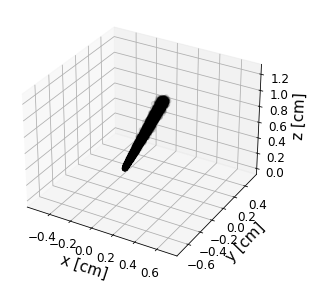

In [7]:
# Plot a Track
index = 0
track = tracks.iloc[index]["track"]
plot_track(track)

# Simulate readout


In [8]:
# the parameters, in order, are:
# peaking time [ns]
# digitization time [ns] 
# pitch of the x strips [um]
# pitch of the y strips [um]
# Threshold of x strips [No. electrons]
# Threshold of y strips [No. electrons]
# Charge sharing [lower strips / upper strips]
# Gain - extrapolating from PHA curve
# drift speed cm/ns
# Include charge integration effect.
# z resolution in cm, must be specified if Charge_integration = False
# Electronic gain in x [mV/fC]
# Electronic gain in y [mV/fC]

def sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = 200, pitch_y = 200,thres_x = 82/9.0*6241.5, thres_y =  82/4.5*6241.5, CS = 0.62, Gain = 505.7, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02, G_x = 9.0, G_y = 4.5):

    #convert pitch to cm
    pitch_x = pitch_x * 1e-4
    pitch_y = pitch_y * 1e-4
    
    # Readout is 10 cm x 10 cm
    x_bins = np.arange(-5,5,pitch_x)
    y_bins = np.arange(-5,5,pitch_y)

    # Find strip edges in x and y
    Left_edges_x = x_bins[0:-1]
    Right_edges_x = x_bins[1:]
    Left_edges_y = y_bins[0:-1]
    Right_edges_y = y_bins[1:]


    hits = pd.DataFrame(columns = ['strips_x', 'strips_y', 'times_x', 'times_y','electrons_x','electrons_y'])

    for index, row in tracks.iterrows():

        track = row.track

        x_positions = []
        x_charges = []
        x_times = []
        adcs0 = []
        strips0 = []

        for L_edge,R_edge in zip(Left_edges_x,Right_edges_x):

            # Bin track over specific strip in x
            T_track = track[(track[:,0]> L_edge) &  (track[:,0]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):


                # If we are incuding the effects of finite charge integration time followed by digitization time
                if Charge_integration == True:

                    # Get time distribution of charge over this strip
                    time_dist = T_track[:,2]/v_drift

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # Keeping only the charge withing peaking time
                    time_dist = time_dist [time_dist < peaking_time]

                    # compute mean time for the hit
                    mean_time = np.mean(time_dist)+min_time

                    # obtain detected charge taking into account primary ionization, gain, and charge sharing
                    charge_detected = len(time_dist) *Gain * CS / (CS+1.0)

                    if charge_detected > thres_x:
                        
                        # obtain mean time for the hit
                        x_times += [mean_time]
                        # obtain position of the hit
                        x_positions += [ (L_edge+R_edge)/2.0 ]
                        # Position expressed consistently with exp digitized data
                        strips0 += [np.where(x_bins == L_edge)[0][0]]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        x_charges += [ charge_detected ]
                        # Charge expressed consistently with exp digitized data
                        adcs0 += [min( charge_detected/6241.5*G_x, 1023.0 ) ]

                # Otherwise we bin the time axis according to the specified z resolution
                else:

                    # Bin in the z-dimension
                    z_bins = np.arange(0,1.2+pitch_z,pitch_z)
                    hist, bin_edges = np.histogram(T_track[:,2],bins=z_bins)
                    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

                    bin_centers = bin_centers[hist>0]
                    hist = hist[hist>0]

                    charge_detected = hist *Gain * CS / (CS+1.0)

                    # only keep hits above threshol
                    bin_centers = bin_centers[charge_detected>thres_x]
                    charge_detected = charge_detected [charge_detected>thres_x]


                    x_times += list(bin_centers/v_drift)
                    x_positions += list( np.ones(len(bin_centers)) * ((L_edge+R_edge)/2.0) )
                    x_charges += list(charge_detected)

        

        y_positions = []
        y_charges = []
        y_times = []
        adcs1 = []
        strips1 = []

        for L_edge,R_edge in zip(Left_edges_y,Right_edges_y):

            # Bin track over specific strip in x
            T_track = track[(track[:,1]> L_edge) &  (track[:,1]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):

                # If we are incuding the effects of finite charge integration time followed by digitization time
                if Charge_integration == True:

                    # Get time distribution of charge over this strip
                    time_dist = T_track[:,2]/v_drift

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # Keeping only the charge withing peaking time
                    time_dist = time_dist [time_dist < peaking_time]

                    # compute mean time for the hit
                    mean_time = np.mean(time_dist)+min_time

                    # obtain detected charge taking into account primary ionization, gain, and charge sharing
                    charge_detected = len(time_dist) * Gain / (CS+1.0)

                    if charge_detected > thres_y:

                        # obtain mean time for the hit
                        y_times += [mean_time]
                        # obtain position of the hit
                        y_positions += [ (L_edge+R_edge)/2.0 ]
                        # Position expressed consistently with exp digitized data
                        strips1 += [np.where(y_bins == L_edge)[0][0]]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        y_charges += [ charge_detected ]
                        # Charge expressed consistently with exp digitized data
                        adcs1 += [ min( charge_detected/6241.5*G_y, 1023.0 ) ] # The min imposes saturation of ADC scale

                # Otherwise we bin the time axis according to the specified z resolution
                else:

                    # Bin in the z-dimension
                    z_bins = np.arange(0,1.2+pitch_z,pitch_z)
                    hist, bin_edges = np.histogram(T_track[:,2],bins=z_bins)
                    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

                    bin_centers = bin_centers[hist>0]
                    hist = hist[hist>0]

                    charge_detected = hist * Gain / (CS+1.0)

                    # only keep hits above threshol
                    bin_centers = bin_centers[charge_detected>thres_y]
                    charge_detected = charge_detected [charge_detected>thres_y]


                    y_times += list(bin_centers/v_drift)
                    y_positions += list( np.ones(len(bin_centers)) * ((L_edge+R_edge)/2.0) )
                    y_charges += list(charge_detected)

        hits = hits.append({'strips_x' : np.array(x_positions), 'strips0' : np.array(strips0),  'strips_y' : np.array(y_positions), 'strips1' : np.array(strips1), 'times_x' : np.array(x_times), 'times0' : np.array(x_times), 'times_y' : np.array(y_times), 'times1' : np.array(y_times), 'electrons_x' :  np.array(x_charges), 'adcs0' :  np.array(adcs0), 'electrons_y' : np.array(y_charges), 'adcs1' :  np.array(adcs1) }, ignore_index = True)
        
    return hits


In [9]:
# Example of readout simulation
hits = sim_readout(tracks)
tracks = pd.concat([tracks,hits],axis=1)
tracks.head()


,direction,start,track,strips_x,strips_y,times_x,times_y,electrons_x,electrons_y,adcs0,adcs1,strips0,strips1,times0,times1
0,"[-0.37628756375856376, 0.16272128455349408, -0...","[0.3104581137971655, -0.16937531522888638, 1.2]","[[0.31183246058587943, -0.1894441912880195, 1....","[-0.17000000000010296, -0.15000000000010338, -...","[-0.1300000000001038, -0.11000000000010424, -0...","[47.52514031629455, 106.02591815685824, 167.89...","[1089.6371916514654, 974.5950862192882, 831.76...","[150186.65679012347, 164315.04074074072, 16683...","[122054.75308641973, 147339.75308641975, 14671...","[216.56331188193724, 236.93589147907818, 240.5...","[87.99910099958164, 106.22909378977631, 105.77...","[241, 242, 243, 244, 245, 246, 247, 248, 249, ...","[243, 244, 245, 246, 247, 248, 249, 250, 251]","[47.52514031629455, 106.02591815685824, 167.89...","[1089.6371916514654, 974.5950862192882, 831.76..."
1,"[-0.2549602665012943, 0.2780006294933591, -0.9...","[0.3620828228578372, 0.17180687343142853, 1.2]","[[0.32005269067317266, 0.17022252256503462, 1....","[0.04999999999989235, 0.06999999999989193, 0.0...","[0.1699999999998898, 0.18999999999988937, 0.20...","[128.16149299029985, 177.4941563321795, 264.28...","[1443.6832769267535, 1371.9805162640048, 1310....","[59416.62839506172, 225860.6037037037, 237860....","[150461.35802469135, 168878.82716049382, 23287...","[85.67646488112722, 325.6821971214184, 342.984...","[108.4797101836275, 121.75834690734955, 167.89...","[252, 253, 254, 255, 256, 257, 258, 259, 260, ...","[258, 259, 260, 261, 262, 263, 264, 265, 266, ...","[128.16149299029985, 177.4941563321795, 264.28...","[1443.6832769267535, 1371.9805162640048, 1310...."
2,"[-0.36181262716689655, -0.0954353290339389, -0...","[-0.19347134014606204, 0.16703706007162078, 1.2]","[[-0.21381649950512446, 0.17782125384459666, 1...","[-0.6300000000000932, -0.6100000000000936, -0....","[0.04999999999989235, 0.06999999999989193, 0.0...","[125.05351535801216, 166.55257294586877, 230.8...","[171.89582881366505, 240.2823704603789, 403.18...","[64642.19506172838, 174185.55555555553, 166056...","[408618.08641975303, 430469.32098765427, 16950...","[93.211528567741, 251.16878955379312, 239.4475...","[294.60568595512115, 310.3600007120795, 122.20...","[218, 219, 220, 221, 222, 223, 224, 225, 226, ...","[252, 253, 254]","[125.05351535801216, 166.55257294586877, 230.8...","[171.89582881366505, 240.2823704603789, 403.18..."
3,"[0.05807606284008047, -0.43389420715696914, -0...","[-0.055405527438300406, 0.09340235346285441, 1.2]","[[-0.04875260811911595, 0.0724840433458185, 1....","[-0.010000000000106368, 0.009999999999893205, ...","[-0.47000000000009656, -0.450000000000097, -0....","[315.216209066738, 142.785906752526, 100.49012...","[53.85977191141692, 93.59344010650241, 146.138...","[76254.56543209875, 437979.9024691357, 90576.4...","[121742.59259259258, 229437.96296296295, 23536...","[109.95611453799388, 631.5499675113708, 130.60...","[87.77403936019653, 165.4203049480627, 169.696...","[249, 250, 251]","[226, 227, 228, 229, 230, 231, 232, 233, 234, ...","[315.216209066738, 142.785906752526, 100.49012...","[53.85977191141692, 93.59344010650241, 146.138..."
4,"[0.4417079625746557, 0.21531429818889866, -0.8...","[0.4789462658246285, -0.4266673326669328, 1.2]","[[0.4961717078157327, -0.4140555258119049, 1.1...","[0.489999999999883, 0.5099999999998825, 0.5299...","[-0.4300000000000974, -0.41000000000009784, -0...","[1457.8826671800919, 1418.4284070681704, 1373....","[1434.0396083923088, 1340.2879864661295, 1237....","[93286.04197530865, 114575.38765432096, 126768...","[148900.55555555553, 153895.1234567901, 155455...","[134.5148406276981, 165.21324823982837, 182.79...","[107.3544019867019, 110.95538821686382, 112.08...","[274, 275, 276, 277, 278, 279, 280, 281, 282, ...","[228, 229, 230, 232, 233, 234, 235, 236, 237, ...","[1457.8826671800919, 1418.4284070681704, 1373....","[1434.0396083923088, 1340.2879864661295, 1237...."


# Perform 3D Reconstruction

[5.40077056e-01 4.45414748e+01 1.00198023e+02 1.55610993e+02
 2.12333266e+02 2.68215585e+02 3.24782520e+02 3.81223873e+02
 4.36718185e+02 4.91893804e+02 5.48900179e+02 6.04824409e+02
 6.59421281e+02 7.16495376e+02 7.73503157e+02 8.25942511e+02
 8.86962952e+02 9.32501874e+02 9.90411437e+02 1.04707540e+03
 1.10363697e+03 1.16217231e+03 1.21750380e+03 1.27213274e+03
 1.32707573e+03 1.38072594e+03 1.43147174e+03 1.49034239e+03
 1.54107387e+03 1.60162543e+03 1.65621979e+03 1.71161211e+03
 1.76002959e+03 1.82484334e+03 1.86896554e+03 1.93198309e+03
 1.97697088e+03 2.02235710e+03 2.08570200e+03 2.13877863e+03
 2.18524459e+03 2.24393307e+03 2.30262836e+03 2.34562372e+03
 2.42506768e+03 2.47725282e+03 2.52961847e+03 2.58366207e+03
 2.63439236e+03 2.68283704e+03 2.74254860e+03 2.78238710e+03
 2.86349193e+03 2.90834458e+03 2.95583802e+03 3.01319829e+03
 3.05303072e+03 3.12282239e+03 3.19614150e+03 3.21237182e+03
 3.30624589e+03 3.34724775e+03 3.38362120e+03 3.45615912e+03
 3.50463863e+03 3.539376

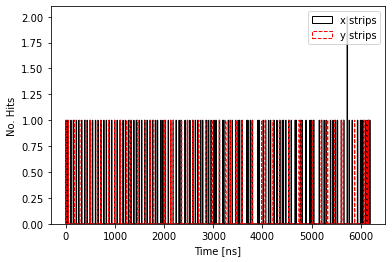

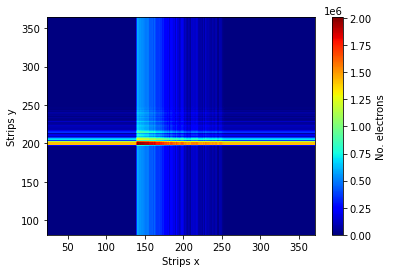

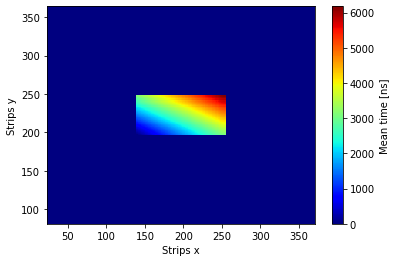

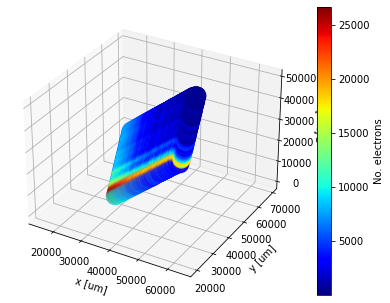

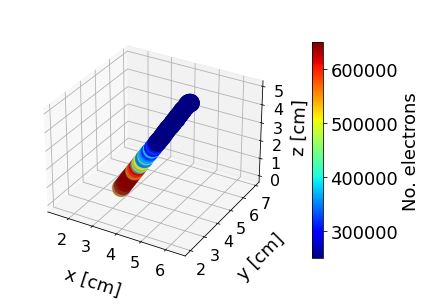

In [25]:
# 3D clustering paramters
mu = T_off.iloc[0]["Mu"]
sigma = T_off.iloc[0]["Sigma"]
n_sigma = 3

# Look at a single event after the cut
test_event = tracks.iloc[12]
# Make a TrackTools object for the event
dsp = stripROtools.TrackTools(event = test_event, Mult_factor = 1.0, gain_x=9, gain_y=4.5, v_drift=8.0)

# Plot 1D time display
dsp.TimeHistView( t_bin =10)

# Plot 2D displays of charge and time
dsp.Strip2DView(fullview = False)
dsp.Strip2DView_times(fullview = False)

# Plot 3D displays
dsp.Reconst3D_v0()
x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma,save_name = "sim_alpha")

# Assess point resolution

In [11]:
def get_PR(tracks, mu = -6.7, sigma = 16.4 , n_sigma = 3, G_x = 9.0, G_y = 4.5, n_strips_x = 500, n_strips_y=500, pitch_x=200, pitch_y=200, theta_min = theta_min, theta_max = theta_max):

    # Analyze point resolution
    all_z = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])



    for index, row in tracks.iterrows():

        try:
            # Make a TrackTools object for the event
            dsp = stripROtools.TrackTools(event = row, Mult_factor = 1.0, gain_x=G_x, gain_y=G_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, v_drift=8.0, pitch_x=pitch_x, pitch_y=pitch_y) # Mult factor always 1 for sim
            
            # Remove delayed hits (as discussed in the slides)
            dsp.prune_track(T_L = 0, T_H=250)
            dsp.prune_track2(gap=2)

            x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma, plot = False)

            
            # Only consider tracks with 5 or more points 
            if len(x) > 5:

                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c, charge_weighting = True)
                
                # Angle to vertical
                ang_z = np.arccos(v_PA[2])*57.2958

                if (ang_z>theta_min) and (ang_z<theta_max):
            
                    all_z = np.append(all_z,z_vals)
                    all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                    all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                    all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                    all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
                

            
        except:
            pass

    # Switch to cm
    all_z = all_z*1E-4

    # Get mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2,plot=False)



    plt.figure()
    plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    #plt.plot(abs_z_std,x_std,color=colors["blue"])
    #plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,200))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")
    plt.show()

    return np.abs(x_sigmas2), x_sigmas_err2, np.abs(y_sigmas2), y_sigmas_err2, abs_z

sigma x:  42.088426391734856 +/- 2.176390210825418
sigma y:  37.90830540408121 +/- 1.7116274525850856
sigma x:  47.54022108867027 +/- 2.831228732810906
sigma y:  44.301397574214356 +/- 2.484092610447295
sigma x:  48.97123105105056 +/- 3.367024907455023
sigma y:  47.2241656700238 +/- 3.1021817692832676
sigma x:  53.0473238768929 +/- 4.313266448805222
sigma y:  47.27905597981485 +/- 3.315879527546859
sigma x:  55.66867171953032 +/- 4.184143392498173
sigma y:  51.04230710805761 +/- 3.7346750556069677
sigma x:  45.605785660780754 +/- 1.1287704025287846
sigma y:  43.47288897966862 +/- 1.058906799785363


/Users/majdghrear/Lab/2DstripRO/stripROtools.py:663: RuntimeWarning: invalid value encountered in reciprocal
  abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)


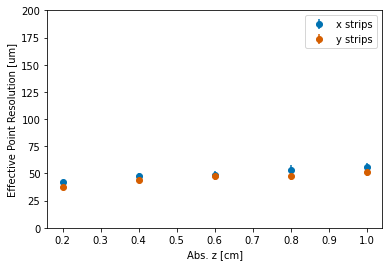

In [12]:
# Example point res calc
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks)

# Simulate Po210 in UH DLC Quadrant a



In [13]:
# Make dataframe to store all results

df_resolution = pd.DataFrame(columns = ['Name','x_res', 'x_res_err', 'y_res', 'y_res_err','abs_z'])

sigma x:  40.28913651360089 +/- 0.8279323353021428
sigma y:  39.00675753466115 +/- 0.8266221783739568
sigma x:  43.35486645018066 +/- 1.0529854669444911
sigma y:  39.44441713241763 +/- 0.8593043185066449
sigma x:  44.07312408952155 +/- 1.089063512083698
sigma y:  44.12454081087242 +/- 1.0906510299127332
sigma x:  49.57039269129804 +/- 1.8602230151574006
sigma y:  46.03669340139121 +/- 1.3447746549811876
sigma x:  48.86245732900989 +/- 1.5682462520037526
sigma y:  48.34658041841178 +/- 1.6974639007673167
sigma x:  -40.60870921474814 +/- 0.3799110203668124
sigma y:  -41.844398364716746 +/- 0.46420672948833047


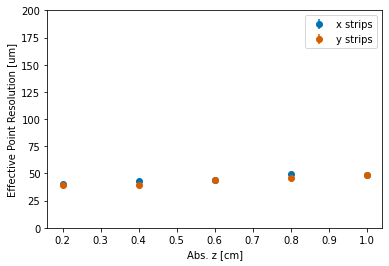

In [14]:
Charge_sharing = 0.41
Gain = 505.7
pitch_x = 200               # in um
pitch_y = 200               # in um
n_strips_x = 500
n_strips_y = 500
electronic_gain_x = 9.0     # in mV/fC
electronic_gain_y = 4.5     # in mV/fC

# 3D clustering paramters
mu = T_off.iloc[0]["Mu"]
sigma = T_off.iloc[0]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 82/electronic_gain_x*6241.5, thres_y =  82/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02, G_x = electronic_gain_x, G_y = electronic_gain_x)
tracks = pd.concat([tracks,hits],axis=1)


# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma, G_x = electronic_gain_x, G_y = electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, pitch_x=pitch_x, pitch_y=pitch_y, theta_min = theta_min, theta_max = theta_max)


df_resolution = df_resolution.append({'Name' : "UH_DLC_a", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



# Simulate Po210 in UH NoDLC Quadrant a

sigma x:  47.960150122882254 +/- 0.8286179959905964
sigma y:  48.514463071783524 +/- 0.8661555251830563
sigma x:  46.92359339256593 +/- 0.8264228663070956
sigma y:  48.72528665513708 +/- 0.9975500011245656
sigma x:  48.861504553346556 +/- 0.9357873666044513
sigma y:  48.309500552330164 +/- 0.9264361441606278
sigma x:  50.4004349739755 +/- 1.0977261737924024
sigma y:  50.13028083107984 +/- 1.0832907961353493
sigma x:  58.481553794190944 +/- 1.420110235534879
sigma y:  58.74992059452422 +/- 1.4549154252562588
sigma x:  48.624058096180676 +/- 0.4253215822059501
sigma y:  48.71092406323163 +/- 0.4394307520981652


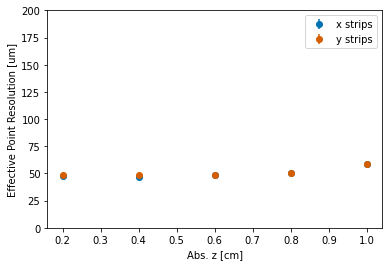

In [15]:
Charge_sharing = 0.62
Gain = 630.8
pitch_x = 200
pitch_y = 200
n_strips_x = 500
n_strips_y = 500
electronic_gain_x = 9.0
electronic_gain_y = 4.5


# 3D clustering paramters
mu = T_off.iloc[4]["Mu"]
sigma = T_off.iloc[4]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 82/electronic_gain_x*6241.5, thres_y =  82/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02, G_x = electronic_gain_x, G_y = electronic_gain_x)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma, G_x = electronic_gain_x, G_y = electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, pitch_x=pitch_x, pitch_y=pitch_y, theta_min = theta_min, theta_max = theta_max )

df_resolution = df_resolution.append({'Name' : "UH_NoDLC_a", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



# Simulate Po210 in UoS

sigma x:  40.71875776099373 +/- 1.2876681182961534
sigma y:  39.79312496875324 +/- 1.2327089931415198
sigma x:  40.90418013900924 +/- 1.2648396845327274
sigma y:  38.18073355181505 +/- 1.0780988612807185
sigma x:  42.08413542235242 +/- 1.4238388483069042
sigma y:  41.52889245547212 +/- 1.3401544824850005
sigma x:  47.13685213280381 +/- 2.0682480363881792
sigma y:  42.513368228235414 +/- 1.4927652532676425
sigma x:  50.138852329258604 +/- 2.528460908162401
sigma y:  51.545454619744426 +/- 2.3345205443273795
sigma x:  43.26520330378031 +/- 0.728041882112542
sigma y:  40.601874734234684 +/- 0.5691627959573216


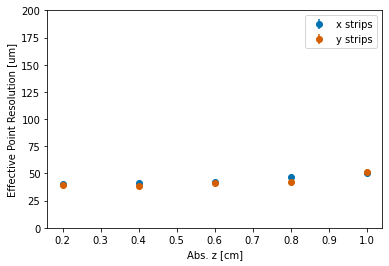

In [16]:
Charge_sharing = 0.13
Gain = 6490
pitch_x = 250
pitch_y = 250
n_strips_x = 358
n_strips_y = 358
electronic_gain_x 
electronic_gain_x= 1.0
electronic_gain_y = 1.0

# 3D clustering paramters
mu = T_off.iloc[8]["Mu"]
sigma = T_off.iloc[8]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 82/electronic_gain_x*6241.5, thres_y =  82/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02, G_x = electronic_gain_x, G_y = electronic_gain_x)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma, G_x = electronic_gain_x, G_y = electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, pitch_x=pitch_x, pitch_y=pitch_y, theta_min = theta_min, theta_max = theta_max )

df_resolution = df_resolution.append({'Name' : "UoS", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



In [17]:
df_resolution.to_pickle("./data/resolution_sim.pk")
df_resolution

,Name,x_res,x_res_err,y_res,y_res_err,abs_z
0,UH_DLC_a,"[41.11546853463489, 42.005214285034825, 45.172...","[0.9201750826904775, 0.8964145049534142, 1.332...","[40.325914735675795, 40.68594121518411, 43.446...","[0.8507159537741418, 0.9116217543339238, 1.027...","[0.2, 0.4, 0.6, 0.8, 1.0]"
1,UH_NoDLC_a,"[48.45428958991054, 46.207126822868794, 46.584...","[0.8447887242545079, 0.7911698409572208, 0.845...","[46.45362472008663, 46.024015446588514, 47.543...","[0.7735217181687978, 0.793808523893467, 0.8728...","[0.2, 0.4, 0.6, 0.8, 1.0]"
2,UoS,"[40.71875776099373, 40.90418013900924, 42.0841...","[1.2876681182961534, 1.2648396845327274, 1.423...","[39.79312496875324, 38.18073355181505, 41.5288...","[1.2327089931415198, 1.0780988612807185, 1.340...","[0.2, 0.4, 0.6, 0.8, 1.0]"


# Appendix: Larger Gain Values

In [32]:
def get_PR_w_expected(tracks, mu = -6.7, sigma = 16.4 , n_sigma = 3, G_x = 9.0, G_y = 4.5, n_strips_x = 500, n_strips_y=500, pitch_x=200, pitch_y=200, theta_min = theta_min, theta_max = theta_max,DTrans = 0.0135):

    # Analyze point resolution
    all_z = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])



    for index, row in tracks.iterrows():

        try:
            # Make a TrackTools object for the event
            dsp = stripROtools.TrackTools(event = row, Mult_factor = 1.0, gain_x=G_x, gain_y=G_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, v_drift=8.0, pitch_x=pitch_x, pitch_y=pitch_y) # Mult factor always 1 for sim
            
            # Remove delayed hits (as discussed in the slides)
            dsp.prune_track(T_L = 0, T_H=250)
            dsp.prune_track2(gap=2)

            x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma, plot = False)

            
            # Only consider tracks with 5 or more points 
            if len(x) > 5:

                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c, charge_weighting = True)
                
                # Angle to vertical
                ang_z = np.arccos(v_PA[2])*57.2958

                if (ang_z>theta_min) and (ang_z<theta_max):
            
                    all_z = np.append(all_z,z_vals)
                    all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                    all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                    all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                    all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
                

            
        except:
            pass

    # Switch to cm
    all_z = all_z*1E-4

    # Get mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2,  start = 0.1, stop = 5.0, step = 0.2, plot=False)



    plt.figure()
    plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    plt.plot(abs_z, np.sqrt( ( 200/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), color=colors["black"] )
    #plt.plot(abs_z_std,x_std,color=colors["blue"])
    #plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,300))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")
    plt.show()

    return np.abs(x_sigmas2), x_sigmas_err2, np.abs(y_sigmas2), y_sigmas_err2, abs_z

sigma x:  54.97702946369805 +/- 0.9406159027500741
sigma y:  52.05363311116853 +/- 0.9430552864239128
sigma x:  49.64603321058271 +/- 0.8403101998349246
sigma y:  52.83969945913223 +/- 0.912158897463897
sigma x:  53.013361366499346 +/- 0.9103854362067058
sigma y:  56.430698392087486 +/- 0.9630228552827095
sigma x:  60.05236368620287 +/- 1.0897017366593837
sigma y:  60.157311953537146 +/- 1.0713545175233732
sigma x:  66.31930885009062 +/- 1.2853054570651992
sigma y:  66.2154650631891 +/- 1.20120884407865
sigma x:  67.85096766939677 +/- 1.243181212998954
sigma y:  70.82184761977314 +/- 1.302856449861922
sigma x:  71.49267987248274 +/- 1.3139107619454893
sigma y:  75.24248271362468 +/- 1.4189991921010678
sigma x:  73.5536869418505 +/- 1.4525819197460905
sigma y:  78.10198722704081 +/- 1.5172166063671264
sigma x:  74.50052638931017 +/- 1.4323477960351045
sigma y:  80.4505496743883 +/- 1.638825691924227
sigma x:  78.09479445780549 +/- 1.5799844137809622
sigma y:  83.03707145422496 +/- 1.721

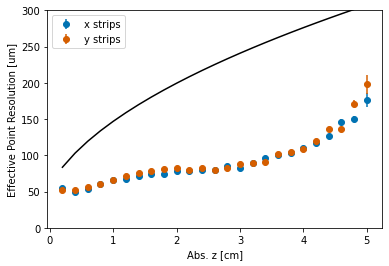

In [34]:
Charge_sharing = 0.62
Gain = 1000
pitch_x = 200
pitch_y = 200
n_strips_x = 500
n_strips_y = 500
electronic_gain_x = 9.0
electronic_gain_y = 4.5


# 3D clustering paramters
mu = T_off.iloc[4]["Mu"]
sigma = T_off.iloc[4]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = 5, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 0.0/electronic_gain_x*6241.5, thres_y =  0.0/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02, G_x = electronic_gain_x, G_y = electronic_gain_x)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR_w_expected(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma, G_x = electronic_gain_x, G_y = electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, pitch_x=pitch_x, pitch_y=pitch_y, theta_min = theta_min, theta_max = theta_max )




[6036.71513364 5665.07629936 5436.97496607 4945.14386051 4971.06517009
 4783.40670873 4480.6511029  3940.88622008 3620.03925893 3463.27602068
 3133.24634716 2719.92864344 2469.25163482 2172.1496928  1862.76061219
 1373.71194339 1242.37394167  933.871898    713.09710104  486.16702845
  259.74943527  107.87748937   59.07871878]


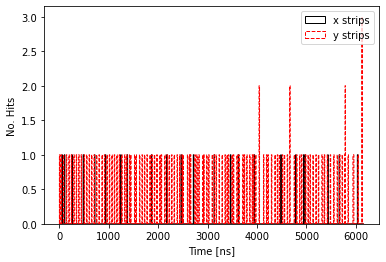

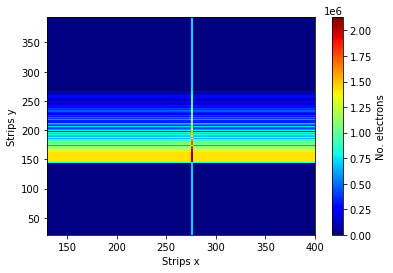

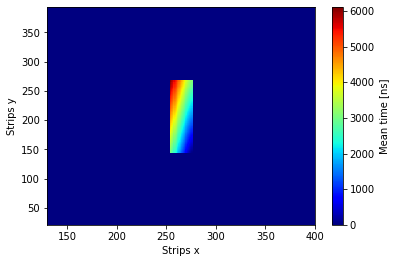

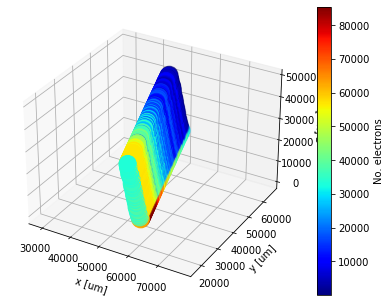

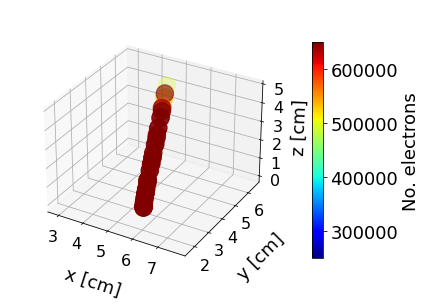

In [27]:
# 3D clustering paramters
mu = T_off.iloc[4]["Mu"]
sigma = T_off.iloc[4]["Sigma"]
n_sigma = 3

# Look at a single event after the cut
test_event = tracks.iloc[0]
# Make a TrackTools object for the event
dsp = stripROtools.TrackTools(event = test_event, Mult_factor = 1.0, gain_x=9, gain_y=4.5, v_drift=8.0)

# Plot 1D time display
dsp.TimeHistView( t_bin =10)

# Plot 2D displays of charge and time
dsp.Strip2DView(fullview = False)
dsp.Strip2DView_times(fullview = False)

# Plot 3D displays
dsp.Reconst3D_v0()
x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma,save_name = "sim_alpha")

# Appendix: Using charge-weighted std

In [18]:
# A function which bins missmeasurments in z and fits them to Gaussians, outputting the results
def Mismeasurment_vs_z_weighted( z_vals, x_mis , y_mis , charge, start = 0.1, stop = 1.0, step = 0.2):

    abs_z_std = []
    x_std_weighted = []
    y_std_weighted = []

    for z_low in np.arange(start,stop,step):

        #make data cut
        z_high = z_low + step
        data_cut = (z_vals > z_low) & (z_vals < z_high)

        x_temp = x_mis[data_cut]
        y_temp = y_mis[data_cut]
        charge_temp = charge[data_cut]
        #charge_temp = np.ones(len(x_temp))

        x_std_weighted += [np.sqrt(np.dot(x_temp*charge_temp,x_temp)/np.sum(charge_temp))]
        y_std_weighted += [np.sqrt(np.dot(y_temp*charge_temp,y_temp)/np.sum(charge_temp))]

        abs_z_std += [round( (z_low+z_high)/2.0 ,2)]


            


    return  abs_z_std, x_std_weighted, y_std_weighted



/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in reciprocal


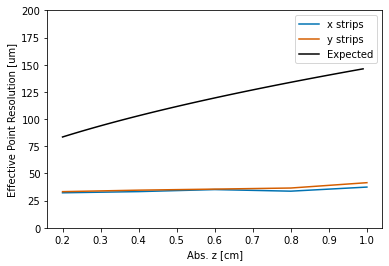

In [14]:
# Analyze point resolution
all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])

all_c = np.array([])



for index, row in tracks.iterrows():

    x,y,z,c = Reconst3D_v1(row.strips_x, row.strips_y, row.times_x, row.times_y, row.electrons_x, row.electrons_y,start=row.start,direction=row.direction, plot = False, save_name = None)

    # Only consider tracks with 5 or more points
    if len(x) > 5:
            
        # Get mismeasurements and absolute z values
        z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = GetTransErrs( x,y,z,c, charge_weighting = True)

        all_z = np.append(all_z,z_vals)
        all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
        all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
        all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
        all_y_err_2 = np.append(all_y_err_2,delta_ys_2)

        all_c = np.append(all_c,c)


# convert mismeaurments to cm 
all_x_err_1 = all_x_err_1 * 10000
all_y_err_1 = all_y_err_1 * 10000
all_x_err_2 = all_x_err_2 * 10000
all_y_err_2 = all_y_err_2 * 10000

# Git mismeasurement versus abs. z using method 1
abs_z_std, x_std, y_std = Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c)

x_ref = np.arange(0.2,1.0,0.01)
y_ref = np.sqrt( (pitch_x*10000/np.sqrt(12))**2 + (np.sqrt(x_ref)*DTrans*10000)**2 )


plt.figure()
plt.plot(abs_z_std,x_std,color=colors["blue"],label="x strips")
plt.plot(abs_z_std,y_std,color=colors["red"],label="y strips")
plt.plot(x_ref,y_ref,color=colors["black"],label="Expected")
plt.legend()
plt.ylim((0,200))
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")
plt.show()


Using a charge-weighted standard deviation agrees with the non-charge weighted standard deviation